This notebook serves as a case study for New Yorker.

Maher Nadar.

In [484]:
import pandas as pd
import numpy as np
import holidays as hol
import pickle

from datetime import datetime, timedelta

import random
import warnings

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid


import seaborn as sns

sns_c = sns.color_palette(palette="deep")

from rich import inspect

from statsmodels.tsa.seasonal import STL


import plotly.express as px
from prophet import Prophet

warnings.filterwarnings("ignore")


In [485]:
filename = "data/sales.csv"

sales_df = pd.read_csv(filename, index_col="date", parse_dates=["date"])
sales_df = sales_df.sort_index()
print(sales_df.shape)

sales_df.dtypes

(103, 7)


Blouse     int64
Dress      int64
Hoodie     int64
Jacket     int64
Shorts     int64
Skirt      int64
T-shirt    int64
dtype: object

# EDA

In [486]:
# plotly layout:
layout = dict(
    xaxis=dict(
        showgrid=False,
    ),
    yaxis=dict(showgrid=False),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
    width=800,
    height=500,
    title_x=0.5,
)

In [487]:
# check null values:
sales_df.isnull().sum() / len(sales_df)

Blouse     0.0
Dress      0.0
Hoodie     0.0
Jacket     0.0
Shorts     0.0
Skirt      0.0
T-shirt    0.0
dtype: float64

In [488]:
sales_df.index.min(), sales_df.index.max()

(Timestamp('2018-09-27 00:00:00'), Timestamp('2020-09-10 00:00:00'))

In [489]:
# total sales calculation:
sales_df["Total_Sales"] = sales_df.sum(axis=1)

# time-related features:
sales_df = sales_df.eval(
    """
	day_of_week = index.dt.day_of_week
	month = index.dt.month
	year = index.dt.year
	"""
)
sales_df.head()

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt,Total_Sales,day_of_week,month,year
date,,,,,,,,,,,
2018-09-27,19194,21046,12573,10720,3309,9791,26523,103156,3,9,2018
2018-10-04,13292,14721,6916,7645,2557,6981,17594,69706,3,10,2018
2018-10-11,19954,20708,7495,9138,3632,9956,23666,94549,3,10,2018
2018-10-18,17547,20016,7913,9693,3565,7894,20586,87214,3,10,2018
2018-10-25,17420,20397,8887,12132,3415,7495,19395,89141,3,10,2018


In [490]:
sales_df.shape

(103, 11)

In [491]:
sales_df.day_of_week.unique()

array([3], dtype=int32)

In [492]:
sales_df.drop(columns=["day_of_week"], inplace=True)

sales_df.index.diff().value_counts(dropna=False)

date
7 days    102
NaT         1
Name: count, dtype: int64

In [493]:
sales_df.tail(20)

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt,Total_Sales,month,year
date,,,,,,,,,,
2020-04-30,8670,25983,895,3170,13361,6486,17558,76123,4,2020
2020-05-07,10315,34154,1340,2990,17682,7398,23896,97775,5,2020
2020-05-14,12357,43405,1794,3773,16507,9335,25298,112469,5,2020
2020-05-21,15492,58726,1901,4320,24738,12078,30649,147904,5,2020
2020-05-28,14034,51869,1344,2896,28241,11423,27367,137174,5,2020
2020-06-04,12151,35397,2270,4087,18194,8199,22777,103075,6,2020
2020-06-11,18047,54419,1774,3390,25648,12839,28162,144279,6,2020
2020-06-18,25931,90338,1428,3134,41945,20774,39301,222851,6,2020
2020-06-25,19681,75223,1396,2852,35663,17558,38000,190373,6,2020


All the collected values are from Wednesdays.
The data is consistently gathered week by week, as the diff function for the dates shows.

In [494]:
# reshaping the dataframe for plotly:
sales_df_plt = pd.melt(
    frame=sales_df.drop(columns=["month", "year"]).reset_index(),
    id_vars=["date"],
    value_vars=sales_df.columns[:-2],
    value_name="purchase_qty",
    var_name="product",
)

In [495]:
fig = px.line(
    sales_df_plt,
    x="date",
    y="purchase_qty",
    color="product",
    title="Purchased Products evolution",
)

fig.update_layout(**layout)

### months analysis

- groupby [year, month] and sum the puchased items.
- groupby month and average the purchased items for each month.
- compare the months behavior of different products in general.

In [496]:
month_analysis_df = (
    (
        sales_df.groupby(
            ["year", "month"]
        )  # getting the sum of purchased items per year,month.
        .sum()
        .reset_index()
    )
    .drop(columns=["year"])  # getting the average sales per product per month.
    .groupby("month")
    .mean()
).reset_index()

In [497]:
# modify the months df for plotly:
month_analysis_df_plt = pd.melt(
    frame=month_analysis_df,
    id_vars=["month"],
    value_vars=month_analysis_df.columns,
    value_name="purchase_qty",
    var_name="product",
)

In [498]:
fig = px.bar(
    month_analysis_df_plt,
    x="month",
    y="purchase_qty",
    color="product",
    barmode="group",
    title="Average purchased products by month of the year",
)

fig.update_layout(**layout)

### Trend + seasonality

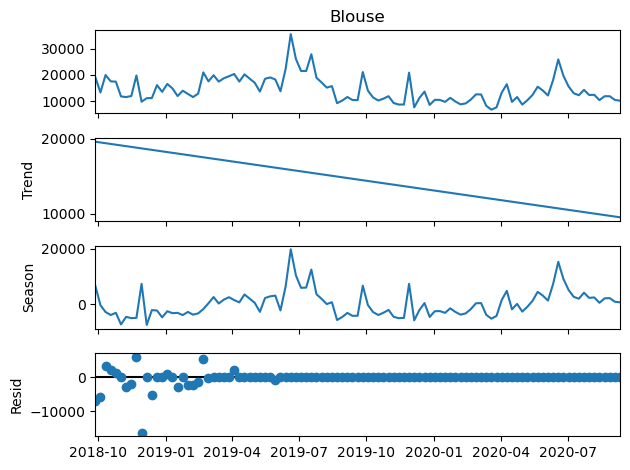

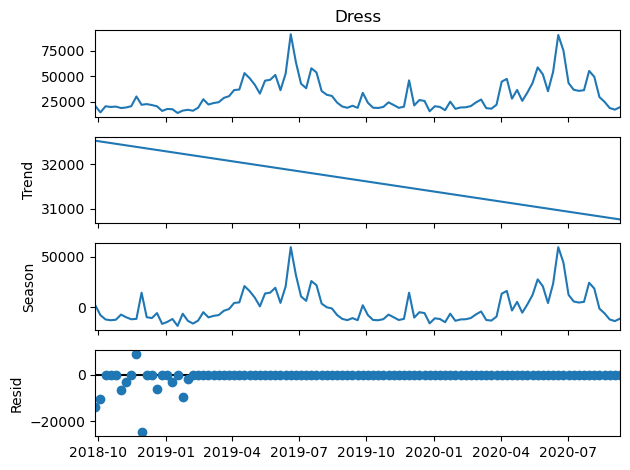

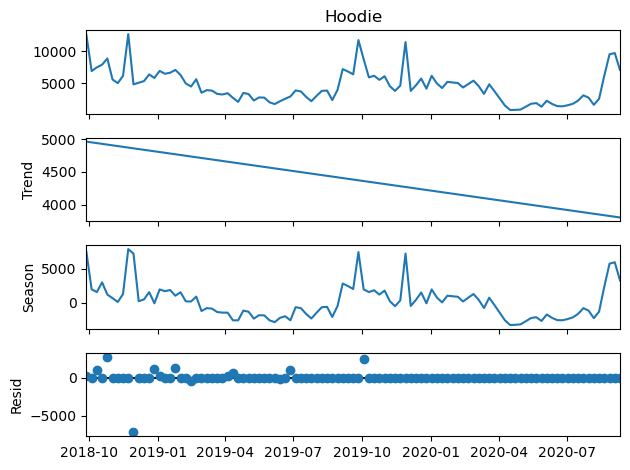

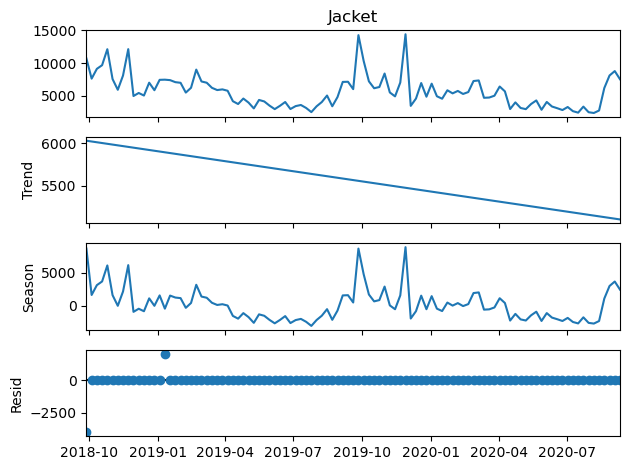

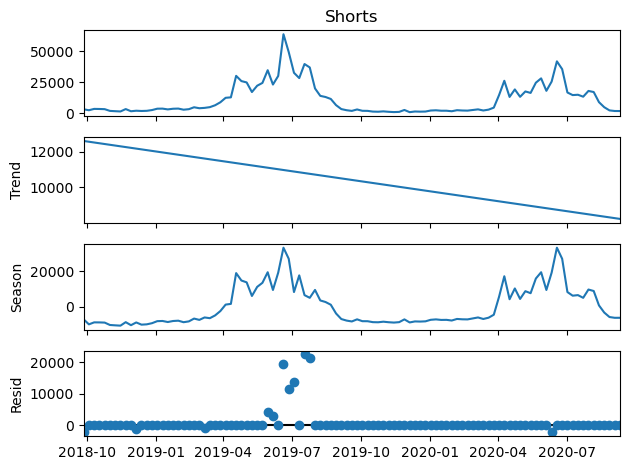

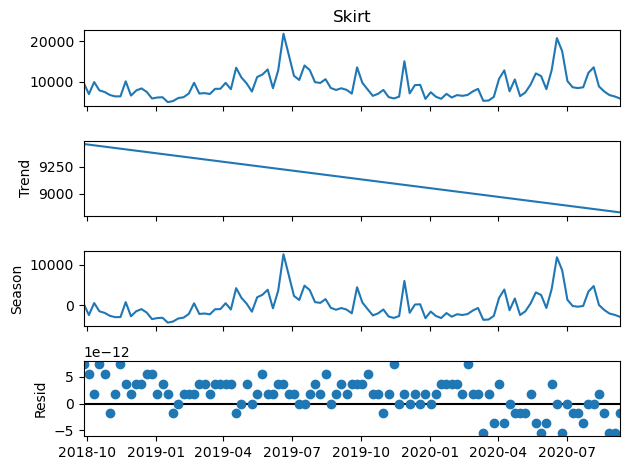

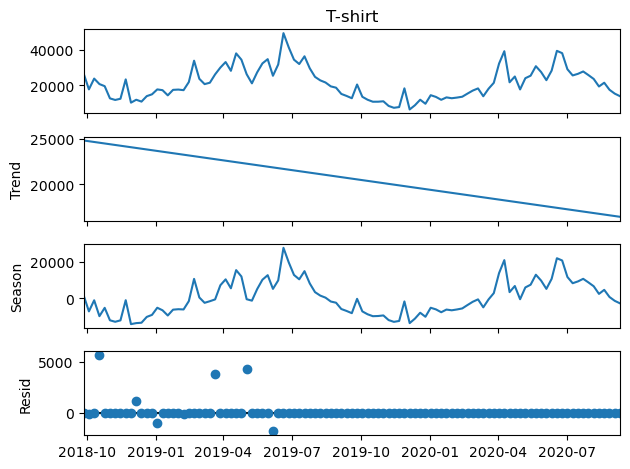

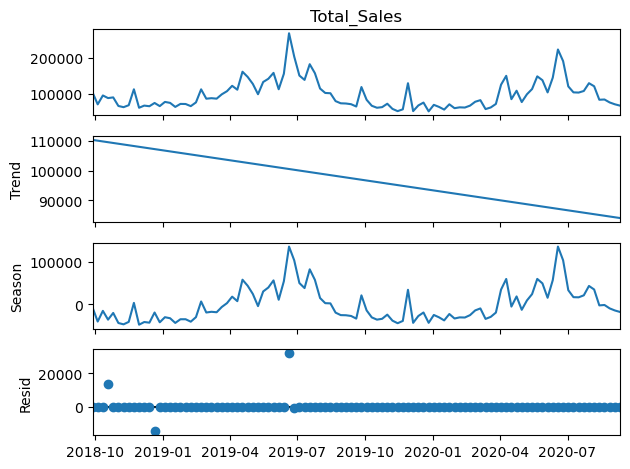

In [499]:
# def time_series_decomposition(data: pd.Series) -> :
columns = [
    "Blouse",
    "Dress",
    "Hoodie",
    "Jacket",
    "Shorts",
    "Skirt",
    "T-shirt",
    "Total_Sales",
]
for col in columns:
    stl = STL(
        sales_df[col], seasonal=53, robust=True
    )  # Seasonal component assumed to have a 103-week period
    result = stl.fit()

    # Plot the decomposition
    fig = result.plot()
    plt.show()

### Correlation between products

Text(0.5, 1.0, 'Correlation between different clothing type purchasing behaviour')

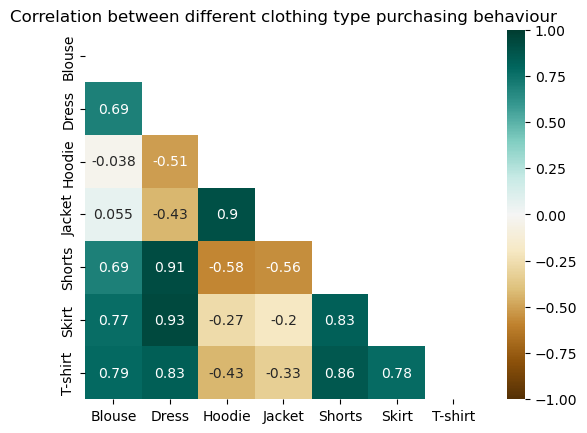

In [500]:
corr_df = sales_df.drop(columns=["year", "month", "Total_Sales"]).corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.title("Correlation between different clothing type purchasing behaviour")

### Product Forecast

Since Dresses are the items that are being bought the most, I will choose this product to forecast, since it would have the most impact on the procurement on time to satisfy the foreseen demand based on the data at hand.

Before we begin, we need to split the data into training and testing sets.
I choose to split the data so that we train to predict on the next 5 weeks.

I will also assume that the country where these sales took place is germany, so I will add the holidays of this country,

In [501]:
stl = STL(
    sales_df["Dress"], seasonal=53, robust=True
)  # Seasonal component assumed to have a 103-week period
result = stl.fit()


def mean_absolute_percentage_error(y_true, y_pred):
    "functio to calculate the mean absolute percentage error"
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Adding holidays


In [502]:
holiday_data = []
for date, name in sorted(hol.Germany(years=[2018, 2019, 2020]).items()):
    holiday_data.append({"ds": date, "holiday": "DE-Holidays"})

holiday = pd.DataFrame(holiday_data)
holiday["ds"] = pd.to_datetime(holiday["ds"], format="%Y-%m-%d", errors="ignore")

holiday.head()

,ds,holiday
0,2018-01-01,DE-Holidays
1,2018-03-30,DE-Holidays
2,2018-04-02,DE-Holidays
3,2018-05-01,DE-Holidays
4,2018-05-10,DE-Holidays


[Text(0.5, 1.0, 'Dress Purchases'), Text(0, 0.5, '')]

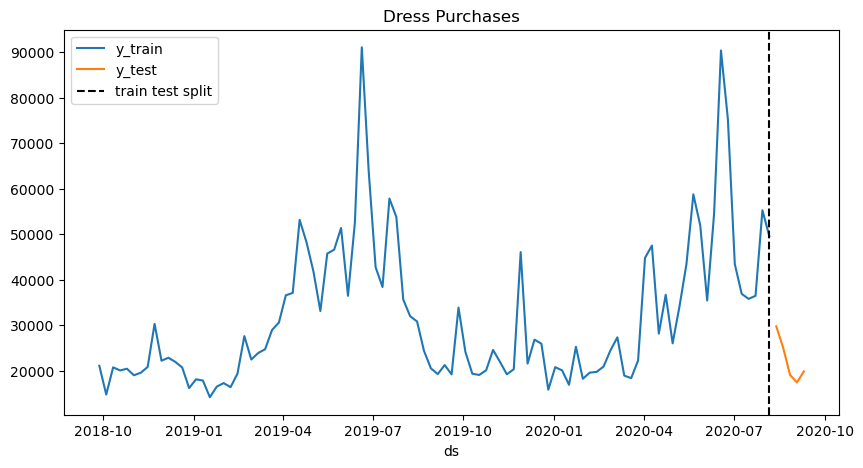

In [503]:
dress_df = sales_df.Dress.sort_index().reset_index()

# Column renaming requested by the "FB Prophet" Package:
dress_df = dress_df.rename(columns={"date": "ds", "Dress": "y"})

train_dress_df = dress_df[:-5]
test_dress_df = dress_df[-5:]

threshold_date = pd.to_datetime("2020-08-06")

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="ds", y="y", label="y_train", data=train_dress_df, ax=ax)
sns.lineplot(x="ds", y="y", label="y_test", data=test_dress_df, ax=ax)

ax.axvline(threshold_date, color="black", linestyle="--", label="train test split")
ax.legend(loc="upper left")
ax.set(title="Dress Purchases", ylabel="")

### Modeling

Remarks:

- We specify to fit the yearly_seasonality with the auto option for the Fourier modes.
- We ask for the 0.95 interval_with instead of the default (0.8).
- We include the mcmc_samples option to get uncertainty in seasonality (via Bayesian sampling).
- We add monthly seasonality by specifying the period and fourier_order. This is the general strategy for adding any type of seasonality

### Hyperparameter tuning based on the MAPE error


In [504]:
params_grid = {
    "seasonality_mode": ("multiplicative", "additive"),
    "changepoint_prior_scale": [0.1, 0.2, 0.3, 0.4, 0.5],
    "holidays_prior_scale": [0.1, 0.2, 0.3, 0.4, 0.5],
    "n_changepoints": [100, 150, 200],
}

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print("Total Possible Models to iterate on: ", cnt)

Total Possible Models to iterate on:  150


In [505]:
# model_parameters = []

# for p in grid:
#     test = pd.DataFrame()
#     print(p)
#     random.seed(0)
#     train_model = Prophet(
#         changepoint_prior_scale=p["changepoint_prior_scale"],
#         holidays_prior_scale=p["holidays_prior_scale"],
#         n_changepoints=p["n_changepoints"],
#         seasonality_mode=p["seasonality_mode"],
#         weekly_seasonality=True,
#         yearly_seasonality=True,
#         holidays=holiday,
#         interval_width=0.95,
#     )
#     train_model.add_country_holidays(country_name="DE")

#     train_model.fit(train_dress_df)
#     train_forecast = train_model.make_future_dataframe(
#         periods=5, freq="W", include_history=False
#     )
#     train_forecast = train_model.predict(train_forecast)

#     test = train_forecast[["ds", "yhat"]]

#     MAPE = mean_absolute_percentage_error(test_dress_df["y"], abs(test["yhat"]))
#     print(
#         "Mean Absolute Percentage Error(MAPE)------------------------------------", MAPE
#     )
#     model_parameters.append({"MAPE": MAPE, "Parameters": p})

# model_parameters_df = pd.DataFrame(model_parameters)

In [506]:
model_parameters_df = model_parameters_df.sort_values(by=["MAPE"]).reset_index(
    drop=True
)
model_parameters_df.head()

,MAPE,Parameters
0,16.869285,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,16.869285,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,16.869285,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,46.188426,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
4,46.188426,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."


In [507]:
model_parameters_df["Parameters"][0]

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative'}

### Final Model

In [508]:
# Setup and train model with holidays
final_model = Prophet(
    changepoint_prior_scale=0.5,
    holidays_prior_scale=0.5,
    n_changepoints=200,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    holidays=holiday,
    interval_width=0.95,
)
final_model.add_country_holidays(country_name="DE")
final_model.fit(train_dress_df)

18:09:41 - cmdstanpy - INFO - Chain [1] start processing


18:09:42 - cmdstanpy - INFO - Chain [1] done processing


In [509]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [520]:
def generate_future_dates(df, column, weeks=2):
	df = df.copy()
	last_existing_date = df.sort_values(by=column)[column].iloc[-1]
	last_index = df.shape[0] - 1

	for i in range(weeks):
		new_index = last_index +1
		new_date = last_existing_date + timedelta(days=7)
		df.loc[new_index, column] = new_date

		last_index = new_index
		last_existing_date = new_date

	return df


In [522]:
future = generate_future_dates(train_dress_df, column='ds', weeks=10)

forecast = final_model.predict(future)

### Visually inspecting the results with testing data:

In [526]:
test_check_df = test_dress_df.merge(
	forecast,
	on='ds',
	copy=False,
	how='left'
)

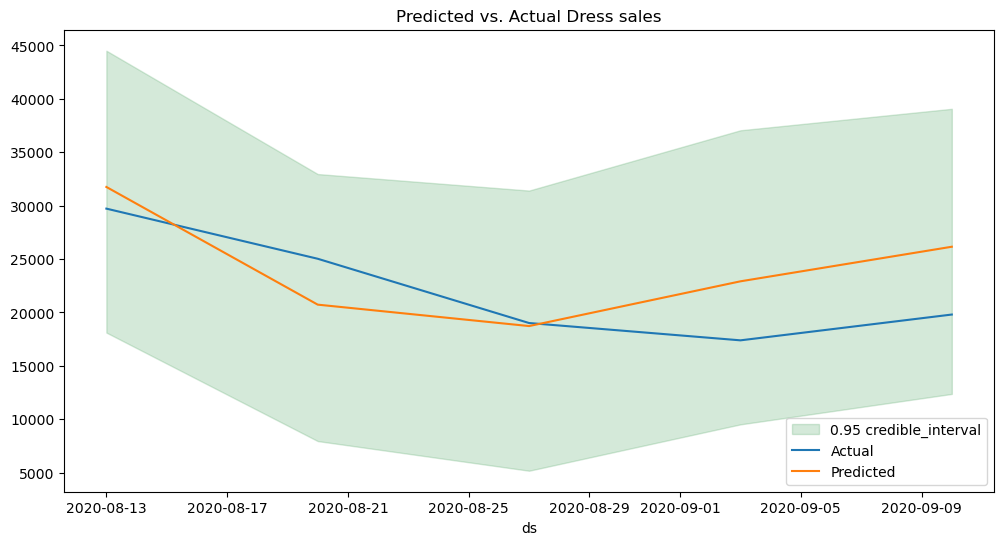

In [532]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.fill_between(
    x=test_check_df['ds'],
    y1=test_check_df['yhat_lower'],
    y2=test_check_df['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='Actual', data=test_check_df, ax=ax)
sns.lineplot(x='ds', y='yhat', label='Predicted', data=test_check_df, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Predicted vs. Actual Dress sales', ylabel='');

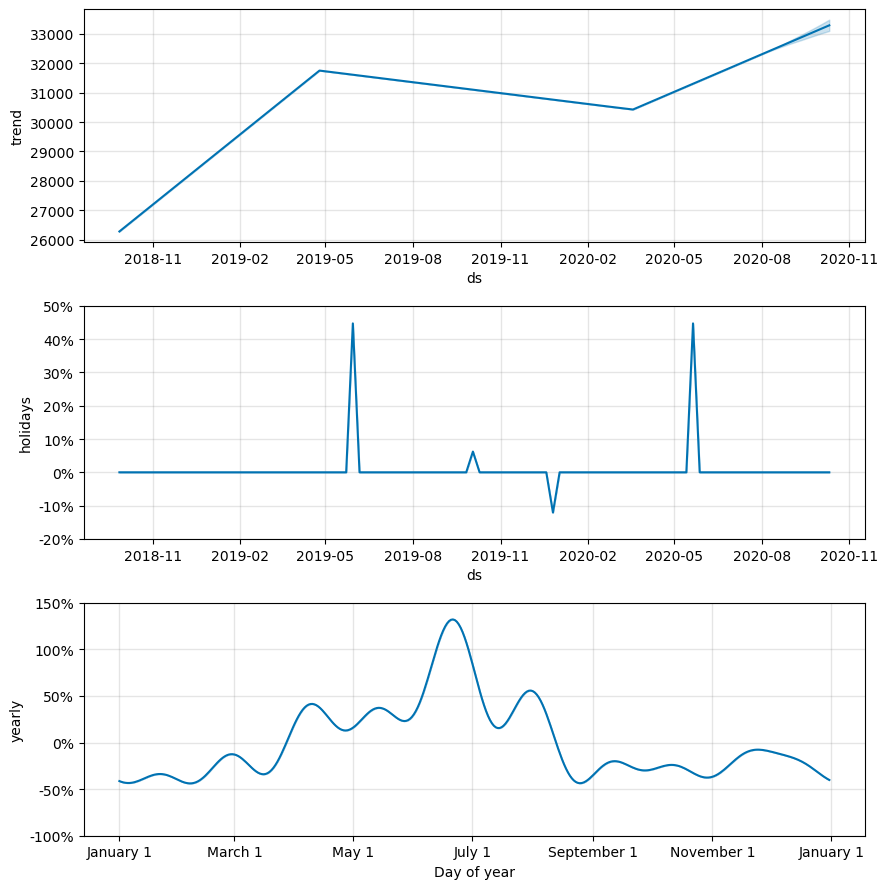

In [516]:
fig = final_model.plot_components(forecast)

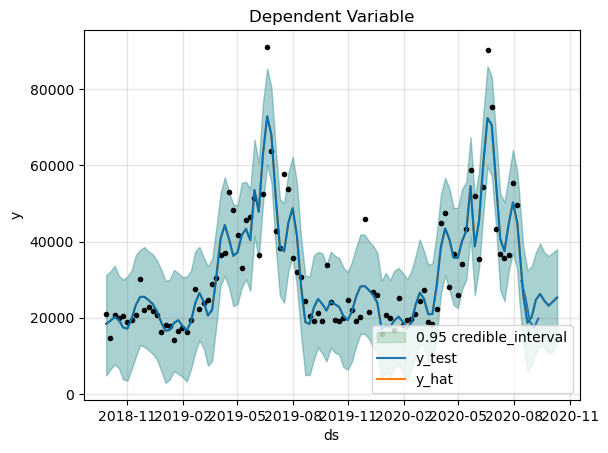

In [517]:
final_model.plot(forecast,ax=ax)

### Forecast for the next 5 weeks with confidence interval:

In [518]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
103,2020-09-13,26248.880940,12745.771959,39472.343928
104,2020-09-20,24449.490457,12194.532477,37078.117214
105,2020-09-27,23187.131780,10604.204289,36198.333056
106,2020-10-04,24228.381233,11082.704261,37074.789928
107,2020-10-11,25297.593356,13499.646744,37980.042634
